# what is mtcnn

이미지 상에서 얼굴의 bbox와 5개의 랜드마크를 detection하는 알고리즘
- Non-max suppression을 사용
<br>

1. image pyramid을 만들기 위해 input image을 여러 번 scaled down<br>
각 scale의 image들이 CNN을 거친다.
2. CNN을 거친 각각의 이미지에서 bbox에 대한 이미지 패치(image patches)을 추출한다.
3. 이미지 패치를 stage2에서는 24x24, stage3에서는 48x48로 resize을 한다.
4. 그리고 그놈들을 CNN에 넣는다.
5. stage3에서는 bbox와 scores 이외에도 각 bbox에 대한 5개의 얼굴 랜드마크를 계산한다.

# dataset Prepare

In [267]:
import glob
import random
import os

In [266]:
data_path = 'data\image\car_license_plate\plate1\detect_recog_image'

image_path_list = glob.glob(data_path + '/*.jpg')

# train : test = 7:3
data_n = len(image_path_list)

train_idx_list = np.random.choice(data_n, int(data_n*0.7), replace = False)
test_idx_list = np.setdiff1d(np.arange(data_n), train_idx_list)

print(len(train_idx_list), len(test_idx_list))

310 134


In [ ]:
for i in train_idx_list:
    img_path = image_path_list[i]
    img_name = img_path.split('\\')[-1]
    print(img_path, img_name)
    os.rename(img_path, data_path + '/train/' + img_name)
    

for j in test_idx_list:
    img_path = image_path_list[j]
    img_name = img_path.split('\\')[-1]
    print(img_path, img_name)
    os.rename(img_path, data_path + '/test/' + img_name)

# Dataset

In [442]:
from facenet_pytorch import MTCNN
import torch
from PIL import Image
from torch.utils.data import Dataset

import cv2

import torch
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [443]:
data_path = 'data\image\car_license_plate\plate1\detect_recog_image'

bbox_frame = pd.read_csv(data_path+'/plate1.csv')
print(bbox_frame.shape)
bbox_frame.head()

(444, 8)


,name,x,y,w,h,text,x_size,y_size
0,AYO9034.jpg,528,412,162,52,AYO9034,720,1280
1,AZJ6991.jpg,560,642,236,76,AZJ6991,1280,1280
2,FZB9581.jpg,967,493,258,83,FZB9581,1280,1280
3,GWT2180.jpg,529,308,227,73,GWT2180,719,1280
4,HPM9362.jpg,584,673,259,84,HPM9362,960,1280


In [554]:
bbox_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 8 columns):
name      444 non-null object
x         444 non-null int64
y         444 non-null int64
w         444 non-null int64
h         444 non-null int64
text      444 non-null object
x_size    444 non-null int64
y_size    444 non-null int64
dtypes: int64(6), object(2)
memory usage: 27.8+ KB


In [555]:
bbox_frame.describe()

,x,y,w,h,x_size,y_size
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,436.768018,372.340090,150.490991,54.396396,753.943694,1050.045045
std,239.435902,204.574632,94.318094,30.550193,324.424747,358.282608
min,-1.000000,1.000000,50.000000,16.000000,199.000000,300.000000
25%,229.000000,207.000000,86.000000,31.000000,480.000000,706.000000
50%,444.000000,319.000000,113.000000,45.000000,720.000000,1280.000000
75%,573.000000,500.500000,211.750000,73.000000,867.000000,1280.000000
max,1642.000000,954.000000,807.000000,262.000000,1632.000000,2048.000000


In [540]:
class MyDataset(Dataset):
    def __init__(self, data_path, bbox_frame, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.bbox_frame = bbox_frame
        
    def __getitem__(self, idx):
        path = self.data_path[idx]
        
        image = Image.open(path)
        image_name = path.split('\\')[-1]
        
        df = bbox_frame[bbox_frame['name'] == image_name]
        bbox = np.array([df.iloc[0, 1:5]], dtype=np.float)
        
        #sample = {'image' : image, 'bbox' : bbox}     
        if self.transform:
            image = self.transform(image)
            #bbox = self.transform(bbox)
        return image, bbox
    
    def __len__(self):
        return len(self.data_path)       

In [556]:
train_path = glob.glob(data_path + '/train/*.jpg')
test_path = glob.glob(data_path + '/test/*.jpg')

transform = transforms.Compose([
    transforms.Resize((753,1050)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,0,0], std=[1,1,1])
])

trainset = MyDataset(data_path=train_path, 
                     bbox_frame=bbox_frame, 
                     transform=transform)
testset = MyDataset(data_path=test_path, 
                     bbox_frame=bbox_frame, 
                     transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False)

example_train = next(iter(trainloader))
example_test = next(iter(testloader))

from torchvision.utils import make_grid
from matplotlib.patches import Rectangle

image_ex = example_train[0]
bbox_ex = example_train[1]

grid = make_grid(image_ex)
grid_numpy = np.array(grid).transpose(1,2,0)

plt.figure(figsize=(10,10))
plt.imshow(grid_numpy)

plt.gca().add_patch(Rectangle((bbox_ex[0][0][0], bbox_ex[0][0][1]), 50, 50, linewidth=1, edgecolor='r'))

In [565]:
bbox_ex[0][0]

tensor([230., 206., 116.,  26.], dtype=torch.float64)

In [561]:
bbox_ex[0][0]

tensor([230., 206., 116.,  26.], dtype=torch.float64)

In [80]:
image_path = 'data/image/face_example4.jpeg'

(630, 462)


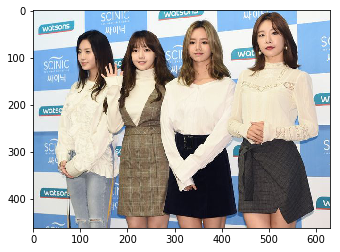

In [106]:
img = Image.open('data/image/face_example4.jpeg')
plt.imshow(img)
print(img.size)

In [126]:
model = MTCNN(
    image_size = 200,
    margin = 100,
    keep_all = True
)

In [145]:
model(img)

tensor([[[[ 0.0820,  0.0742,  0.0664,  ...,  0.9336,  0.9258,  0.9258],
          [ 0.0820,  0.0742,  0.0664,  ...,  0.9336,  0.9258,  0.9258],
          [ 0.0820,  0.0742,  0.0742,  ...,  0.9336,  0.9258,  0.9258],
          ...,
          [ 0.9023,  0.9102,  0.9258,  ...,  0.8555,  0.8555,  0.8555],
          [ 0.9102,  0.9180,  0.9258,  ...,  0.8555,  0.8477,  0.8477],
          [ 0.9258,  0.9258,  0.9336,  ...,  0.8477,  0.8398,  0.8398]],

         [[ 0.5273,  0.5273,  0.5352,  ...,  0.9492,  0.9414,  0.9414],
          [ 0.5273,  0.5273,  0.5352,  ...,  0.9492,  0.9414,  0.9414],
          [ 0.5273,  0.5273,  0.5352,  ...,  0.9492,  0.9414,  0.9414],
          ...,
          [ 0.8555,  0.8555,  0.8633,  ...,  0.7695,  0.7695,  0.7695],
          [ 0.8633,  0.8633,  0.8711,  ...,  0.7695,  0.7695,  0.7695],
          [ 0.8711,  0.8711,  0.8789,  ...,  0.7695,  0.7617,  0.7617]],

         [[ 0.9414,  0.9414,  0.9414,  ...,  0.9258,  0.9180,  0.9180],
          [ 0.9414,  0.9414,  

In [127]:
output = model(img)
output.shape

torch.Size([4, 3, 200, 200])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


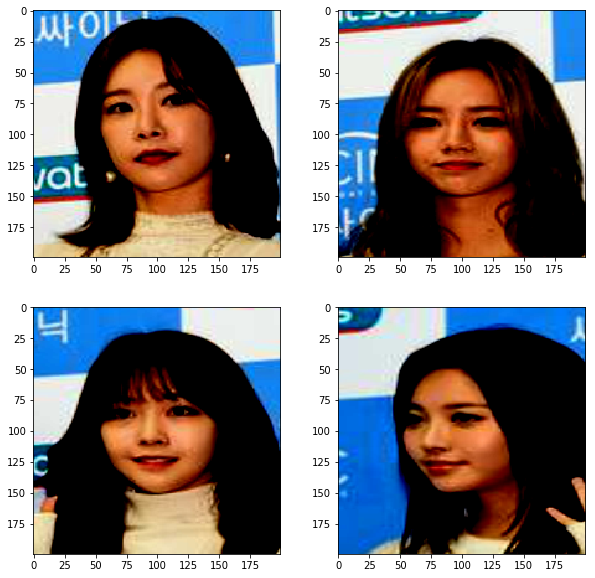

In [129]:
plt.figure(figsize = (10,10))

for i in range(output.shape[0]):
    plt.subplot(2,2,i+1)
    plt.imshow(output[i].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


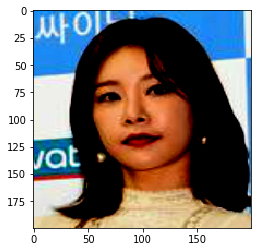

In [125]:
plt.imshow(output.permute(1,2,0))

In [58]:

help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and, given raw input images as PIL images,
 |  returns images cropped to include the face only. Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the davidsandberg/facenet
 |          repo, which applies the margin to the original image before resizing, making the margin
 |          dependent on the original image size (this is a bug in davidsandberg/facenet).
 |          (default: {0})
 |      min_face_size {int} -- Minimum face size to search for. (default: {20})
 |      thresholds {list} -- MTCN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


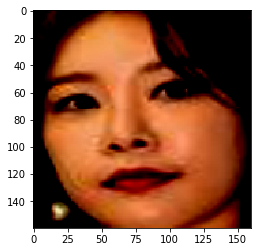

In [57]:
model = MTCNN()
plt.imshow(np.array(model(img).permute(1,2,0)))